In [ ]:
import datetime
import os

import pandas as pd

from src.config import DATA_DIR, MODEL_DIR, PARAM_DIR
from src.recommendation.FPMC import train_fpmc_model, model_type
from src.recommendation.all_evaluation import _results
from src.util.data_io import get_dataset, get_fpmc_dataset
from src.util.eval_measures import eval_lst
from src.util.io import save_pickle


In [3]:
k_vals = [5, 10, 50, 100, 500]

train_model, model_type = train_fpmc_model, model_type
data_dir = os.path.join(DATA_DIR, 'day')
results_dir = os.path.join(MODEL_DIR, 'tuning')

# subset Jan 20 - 22, 2015
datasets = ['120', '121', '122']

print(model_type)
print(eval_lst)

fpmc_model
[['recall', [5]], ['precision', [5]], ['nDCG', [5]]]


In [4]:
def hours_minutes_seconds(td):
    return '{:02}:{:02}:{:02}'.format(td.seconds // 3600, (td.seconds // 60) % 60, td.seconds % 60)


def eval_dataset(dataset, k_vals):
    result_dic = {}
    input_data = get_fpmc_dataset(dataset, data_dir)
    train, val, test = get_dataset(dataset, data_dir)

    for n_components in k_vals:
        print(n_components)

        start_time = datetime.datetime.now()
        all_multinomials = train_model(input_data, results_dir, dataset, n_components, n_epoch=150,
                                       regular=0.001, n_neg=10, lr=0.01, overwrite=True,
                                       save_multinomials=False, save_model=False)

        end_time = datetime.datetime.now()
        time_used = hours_minutes_seconds(end_time - start_time)
        print('time_used', time_used)
        dataset, eval_result = _results(dataset, eval_lst, val, all_multinomials)
        eval_result.append(['time_used', time_used])
        result_dic.update({n_components: eval_result})

    df = pd.DataFrame(result_dic).T
    df.columns = [item for sublist in list(result_dic.values())[0] for item in sublist[:1]]
    for col in df.columns:
        df[col] = df[col].apply(lambda s: s[1])

    return df


In [5]:
dfs = dict()
for dataset in datasets:
    dataset = str(dataset)
    df = eval_dataset(dataset, k_vals)
    dfs.update({dataset: df})


2019-10-23 13:00:55,830 INFO --> Loading data for 120
5
time_used 00:24:36
recall@5: 0.04581
precision@5: 0.04452
nDCG@5: 0.05959
10
time_used 00:25:31
recall@5: 0.05468
precision@5: 0.04930
nDCG@5: 0.06275
50
time_used 00:38:39
recall@5: 0.41041
precision@5: 0.37319
nDCG@5: 0.46394
100
time_used 01:00:28
recall@5: 0.48460
precision@5: 0.45297
nDCG@5: 0.56167
500
time_used 02:14:44
recall@5: 0.51071
precision@5: 0.48188
nDCG@5: 0.59860
2019-10-23 17:49:37,077 INFO --> Loading data for 121
5
time_used 00:25:25
recall@5: 0.04259
precision@5: 0.04543
nDCG@5: 0.05734
10
time_used 00:26:55
recall@5: 0.05313
precision@5: 0.04839
nDCG@5: 0.05945
50
time_used 00:36:28
recall@5: 0.42255
precision@5: 0.39846
nDCG@5: 0.48703
100
time_used 00:46:57
recall@5: 0.51098
precision@5: 0.49800
nDCG@5: 0.60766
500
time_used 02:17:44
recall@5: 0.53390
precision@5: 0.52299
nDCG@5: 0.63976
2019-10-23 22:27:41,445 INFO --> Loading data for 122
5
time_used 00:25:20
recall@5: 0.04606
precision@5: 0.04662
nDCG@5

In [6]:
eval_measure = df.columns.tolist()
eval_measure


['recall@5', 'precision@5', 'nDCG@5', 'time_used']

In [7]:
def plot_metric(col):
    try:
        df_plot = pd.DataFrame({c: df[col] for c, df in dfs.items()})
        df_plot.plot(logx=True, xticks=k_vals, title=col.upper() + ' for different k')
    except:
        # time is not numeric value
        return df_plot


In [8]:
for k, df in dfs.items():
    print(k)
    print(df['nDCG@5'].idxmax())


120
500
121
500
122
500


          120       121       122
5    00:24:36  00:25:25  00:25:20
10   00:25:31  00:26:55  00:26:54
50   00:38:39  00:36:28  00:36:21
100  01:00:28  00:46:57  00:47:08
500  02:14:44  02:17:44  02:18:45


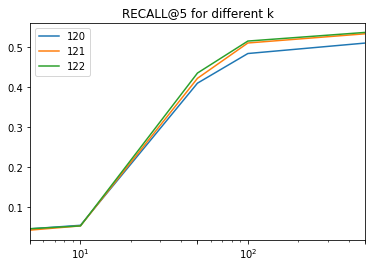

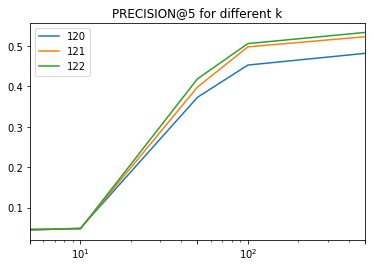

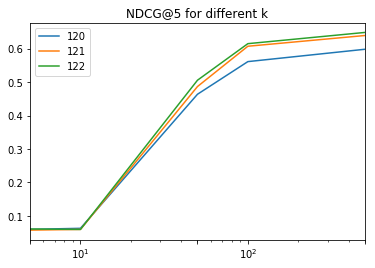

In [9]:
for col in eval_measure:
    df_time = plot_metric(col)
print (df_time)

In [10]:
save_pickle(os.path.join(PARAM_DIR, model_type), 500, False)